In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

## Preparing datasets from both models

In [3]:
# Load in data
mut_ga = pd.read_csv("mutational_growth_advantages.tsv", sep="\t")
#mut_ga = pd.read_csv("new_mutational_growth_advantages.tsv", sep="\t")
innovation_ga = pd.read_csv("mlr_innovation_growth_advantages.tsv", sep="\t")
parent_variant_relationships = pd.read_csv("../count-data/pango_variant-relationships.tsv", sep="\t").set_index("variant")

In [4]:
# Prep to merge
def clean_and_merge(innovation_ga, mut_ga, parent_variant_relationships):
    innovation_ga = (innovation_ga
                     .rename(columns={"median_ga": "innov-ga"})
                     [["variant", "innov-ga"]])

    mut_ga = (mut_ga
              .rename(columns={"median_ga": "mut-ga"})
              [["variant", "mut-ga"]])

    ga_df = innovation_ga.merge(mut_ga, how="right").set_index("variant")
    ga_df["mut-ga"] = ga_df["mut-ga"] / ga_df.loc["BA.2.1"]["mut-ga"] # Scale GA by BA.2.1

    # Add parents
    def _get_parent(row):
        variant = row.name
        if variant in parent_variant_relationships.index:
            return parent_variant_relationships.loc[variant]
        return "NAN"

    ga_df["parent"] = ga_df.apply(_get_parent, axis=1)
    return ga_df

ga_df = clean_and_merge(innovation_ga, mut_ga, parent_variant_relationships)

In [5]:
# Look for parent for mut-parent-ga
def add_deltas(row, prefix):
    # Give up if parent not found
    if row.parent not in ga_df.index:
        return pd.Series([np.nan, np.nan],
                         index=[prefix + "-parent-ga", prefix + "-pc-ratio"])
    # Get child growth advantage
    parent_row = ga_df.loc[row.parent]
    
    # Return parent ga and ratio
    return pd.Series([parent_row[prefix + "-ga"],  row[prefix + "-ga"] / parent_row[prefix + "-ga"]],
                         index=[prefix + "-parent-ga", prefix + "-pc-ratio"])
    
ga_df[["mut-parent-ga", "mut-pc-ratio"]] = ga_df.apply(add_deltas, prefix="mut", axis=1)
ga_df[["innov-parent-ga", "innov-pc-ratio"]] = ga_df.apply(add_deltas, prefix="innov", axis=1)

## Quick plots

Text(0, 0.5, 'Mutation GA')

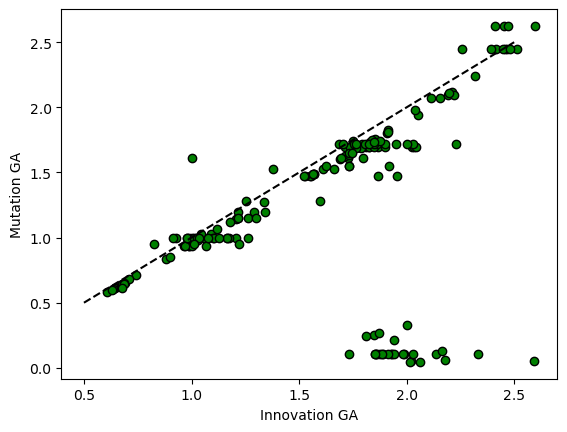

In [5]:
# Total growth advantage from various models
plt.scatter(ga_df["innov-ga"], ga_df["mut-ga"], color="g", ec="k")
plt.plot([0.5, 2.5], [0.5, 2.5], color="k", linestyle="--")
plt.xlabel("Innovation GA")
plt.ylabel("Mutation GA")


# What are those in the corner?

In [6]:
# Notice this is mostly things decended from BA.2.75 or BA.5
ga_df[ga_df["mut-ga"] < 0.5]

,innov-ga,mut-ga,parent,mut-parent-ga,mut-pc-ratio,innov-parent-ga,innov-pc-ratio
variant,,,,,,,
BA.2.75,2.021274,0.048918,BA.2,NaN,NaN,NaN,NaN
BA.2.75.1,2.013931,0.047167,BA.2.75,0.048918,0.964195,2.021274,0.996367
BA.2.75.2,2.180267,0.060537,BA.2.75,0.048918,1.237506,2.021274,1.078660
BA.2.75.5,2.063560,0.045396,BA.2.75,0.048918,0.928006,2.021274,1.020920
BA.5.1.21,1.846614,0.248369,BA.5.1,1.692330,0.146762,1.784575,1.034764
BA.5.10.1,2.000346,0.328307,BA.5,1.692330,0.193997,1.771832,1.128971
BA.5.2.16,1.930347,0.102519,BA.5.2,1.715751,0.059752,1.862826,1.036247
BA.5.2.19,1.927386,0.109233,BA.5.2,1.715751,0.063665,1.862826,1.034657
BA.5.2.2,1.732573,0.109233,BA.5.2,1.715751,0.063665,1.862826,0.930077


In [6]:
def is_outlier_IQR(data, col, scale=1.5):
    """
    Find wheter outliers in column col from dataframe data
    Uses IQR rule based on normal approximation.
    """

    Q3 = np.quantile(data[col], 0.75)
    Q1 = np.quantile(data[col], 0.25)
    IQR = Q3 - Q1
    lower_bound = Q1 - scale * IQR
    upper_bound = Q3 + scale * IQR
    return (data[col] < lower_bound) | (data[col] > upper_bound)

    
ga_df["innov-mut-ratio"] = ga_df["innov-ga"] / ga_df["mut-ga"]
ga_df["log-innov-mut-ratio"] = np.log(ga_df["innov-ga"] / ga_df["mut-ga"])
ga_df["outlier"] = is_outlier_IQR(ga_df, "log-innov-mut-ratio") # log-innov-mut-ratio ~ Normal()

Text(0, 0.5, 'Mutation GA')

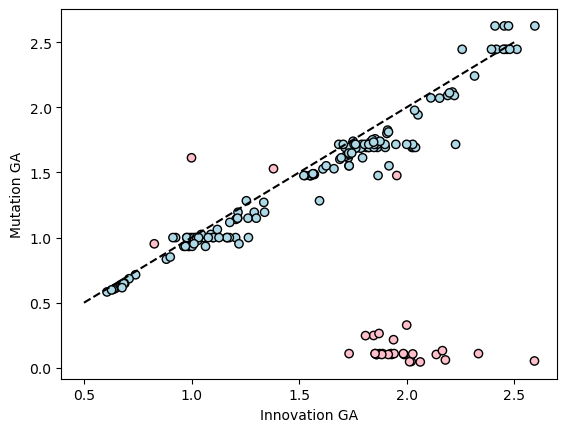

In [8]:
# Coloring by outlier
plt.scatter(ga_df["innov-ga"], ga_df["mut-ga"], 
            color=["pink" if value else "lightblue" for value in ga_df.outlier], 
            ec="k")
plt.plot([0.5, 2.5], [0.5, 2.5], color="k", linestyle="--")
plt.xlabel("Innovation GA")
plt.ylabel("Mutation GA")

Text(0.5, 0, 'Innovation / Mutational Branch Growth Advantage')

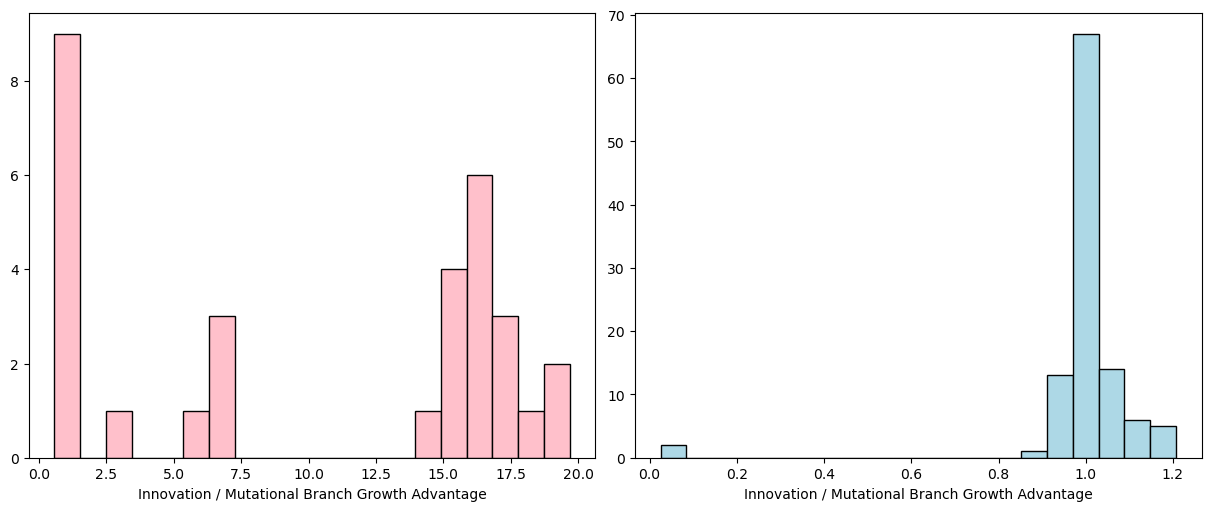

In [9]:
# Growth advantage along branch from each model
fig = plt.figure(figsize=(12., 5.), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=1)
ax0 = fig.add_subplot(spec[0, 0])
ax1 = fig.add_subplot(spec[0, 1])

ga_df_outlier = ga_df[ga_df["outlier"]]
ga_df_nonoutlier = ga_df[~ga_df["outlier"]]

ax0.hist(ga_df_outlier["innov-pc-ratio"] / ga_df_outlier["mut-pc-ratio"], 
            color="pink", bins=20,
            ec="k")
ax0.set_xlabel("Innovation / Mutational Branch Growth Advantage")
ax1.hist(ga_df_nonoutlier["innov-pc-ratio"] / ga_df_nonoutlier["mut-pc-ratio"],
            color="lightblue", bins=20,
            ec="k")
ax1.set_xlabel("Innovation / Mutational Branch Growth Advantage")

#plt.plot([0.1, 3.0],  [0.1, 3.0], color="k", linestyle="--")
#plt.xlim(0,3) # There's some huge mutation outliers
#plt.yscale("log")
#plt.xscale("log")

(0.0, 3.0)

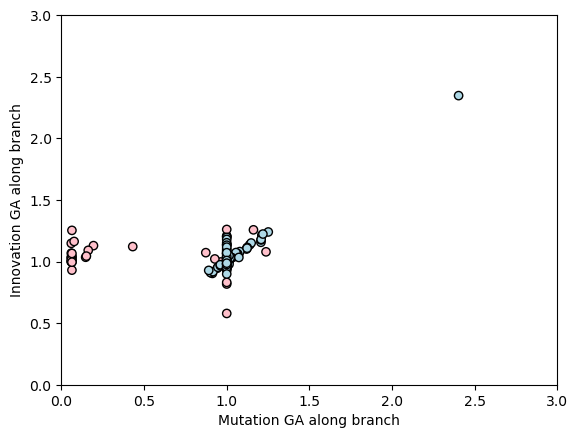

In [10]:
plt.scatter(ga_df["mut-pc-ratio"], ga_df["innov-pc-ratio"],
            color=["pink" if value else "lightblue" for value in ga_df.outlier], 
            ec="k")
plt.ylabel("Innovation GA along branch")
plt.xlabel("Mutation GA along branch")
plt.xlim(0, 3)
plt.ylim(0, 3)

In [11]:
# Looking at outliers outside of bottom right corner
ga_df[ga_df.outlier & (ga_df["mut-pc-ratio"] > 0.5)]

,innov-ga,mut-ga,parent,mut-parent-ga,mut-pc-ratio,innov-parent-ga,innov-pc-ratio,innov-mut-ratio,log-innov-mut-ratio,outlier
variant,,,,,,,,,,
BA.2.75.1,2.013931,0.047167,BA.2.75,0.048918,0.964195,2.021274,0.996367,42.698204,3.754157,True
BA.2.75.2,2.180267,0.060537,BA.2.75,0.048918,1.237506,2.021274,1.078660,36.015742,3.583956,True
BA.2.75.5,2.063560,0.045396,BA.2.75,0.048918,0.928006,2.021274,1.020920,45.456535,3.816757,True
BA.2.9.2,0.827023,0.952277,BA.2.9,0.952277,1.000000,1.011660,0.817491,0.868470,-0.141023,True
BA.4.1.9,1.954345,1.476645,BA.4.1,1.476645,1.000000,1.550637,1.260350,1.323504,0.280283,True
BE.1.1.2,1.939237,0.216001,BE.1.1,0.247316,0.873380,1.809047,1.071966,8.977909,2.194767,True
BE.5,1.000000,1.612550,BA.5.3.1,1.612550,1.000000,1.728509,0.578533,0.620136,-0.477817,True
BF.1.1,1.381166,1.528722,BF.1,1.528722,1.000000,1.662383,0.830835,0.903478,-0.101504,True
BN.1,2.594340,0.052733,BA.2.75.5,0.045396,1.161616,2.063560,1.257216,49.197537,3.895844,True


In [12]:
# Looking at outliers inside of bottom right corner
ga_df[ga_df.outlier & (ga_df["mut-pc-ratio"] < 0.5)]

,innov-ga,mut-ga,parent,mut-parent-ga,mut-pc-ratio,innov-parent-ga,innov-pc-ratio,innov-mut-ratio,log-innov-mut-ratio,outlier
variant,,,,,,,,,,
BA.5.1.21,1.846614,0.248369,BA.5.1,1.692330,0.146762,1.784575,1.034764,7.434960,2.006193,True
BA.5.10.1,2.000346,0.328307,BA.5,1.692330,0.193997,1.771832,1.128971,6.092916,1.807127,True
BA.5.2.16,1.930347,0.102519,BA.5.2,1.715751,0.059752,1.862826,1.036247,18.829140,2.935406,True
BA.5.2.19,1.927386,0.109233,BA.5.2,1.715751,0.063665,1.862826,1.034657,17.644788,2.870440,True
BA.5.2.2,1.732573,0.109233,BA.5.2,1.715751,0.063665,1.862826,0.930077,15.861318,2.763883,True
BA.5.2.20,1.874296,0.109233,BA.5.2,1.715751,0.063665,1.862826,1.006157,17.158768,2.842509,True
BA.5.2.21,1.854681,0.109233,BA.5.2,1.715751,0.063665,1.862826,0.995627,16.979192,2.831989,True
BA.5.2.22,1.941731,0.109233,BA.5.2,1.715751,0.063665,1.862826,1.042358,17.776117,2.877856,True
BA.5.2.24,2.137971,0.102519,BA.5.2,1.715751,0.059752,1.862826,1.147703,20.854358,3.037563,True


In [13]:
# there are somehow no outliers in the dataset not counting BA.2 mutations??
ga_df.outlier

variant
B.1.1.529    False
BA.1         False
BA.1.1       False
BA.1.1.1     False
BA.1.1.10    False
             ...  
BQ.1.14      False
BQ.1.2       False
BQ.1.3       False
BQ.1.6       False
other        False
Name: outlier, Length: 178, dtype: bool

## Finding Common Mutations in Outliers

In [7]:
def find_common_mutations(data):
    """
    Find common mutations in given dataset
    Based off of accumulated mutations on BA.2 rooted phylogenetic tree
    """
    # load in outliers
    outliers = data.index
    # load in accumulated mutations dataframe
    mutations = pd.read_csv("new_accumulated_mutations_output.tsv", sep="\t")
    mutation_variants = mutations['variant'].values
    mutation_count = {}
    # for every outlier
    for variant in outliers:
        # if outlier is variant in mutation
        if variant in mutation_variants:
            # mutation = mutation + region
            rows = mutations.loc[mutations['variant'] == variant]
            rows = rows.reset_index()
            for index, r in rows.iterrows():
                mutation = r['mutation'] + "_" + r['region']
                # else update value to get(key) + 1
                if mutation in mutation_count:
                    mutation_count[mutation] = mutation_count[mutation] + 1
                #if key does not exist, add (mutation, 1)
                else:
                    mutation_count.update({mutation:1})

    # save dictionary as df
    df = pd.DataFrame.from_dict(mutation_count, orient='index', columns = ['count'])
    return df

In [24]:
# load in outliers in bottom right corner dataframe
outliers_bottom_right = ga_df[ga_df.outlier & (ga_df["mut-pc-ratio"] < 0.5)]
br_df = find_common_mutations(outliers_bottom_right)
# Looking at outliers outside of bottom right corner
outliers_top_left = ga_df[ga_df.outlier & (ga_df["mut-pc-ratio"] > 0.5)]
tl_df = find_common_mutations(outliers_top_left)
#grab top 10 mutations in bottom right dataframe
top_10_br = br_df.nlargest(10, 'count')
top_10_br.to_csv('top_10_mutations_bottom_right.tsv', sep='\t')
br_df.to_csv('all_bottom_right_outlier_mutations.tsv', sep='\t')
#grab top 10 mutations in top left dataframe
top_10_tl = tl_df.nlargest(10, 'count')
top_10_tl.to_csv('top_10_mutations_top_left.tsv', sep='\t')
tl_df.to_csv('all_top_left_outlier_mutations.tsv', sep='\t')

TypeError: Column 'count' has dtype object, cannot use method 'nlargest' with this dtype

## Finding Common Pairwise Mutations

Need to double check if I am double counting pairs (order shouldn't matter)

In [22]:
mutations_df = pd.read_csv("accumulated_mutations_output.tsv", sep="\t")
mutations_df = mutations_df[mutations_df.variant != 'BA.2']

In [23]:
# Viewing mutations after deleting BA.2 mutations
mutations_df

,Unnamed: 0,variant,mutation,region
0,0,XA,S3L,E
1,1,XA,S6L,E
2,2,XA,T9I,E
3,3,XA,T11M,E
4,4,XA,L18F,E
...,...,...,...,...
403550,403550,CK.2.1.1,D3N,M
403551,403551,CK.2.1.1,L61D,ORF6
403552,403552,CK.2.1.1,D61L,ORF6
403553,403553,CK.2.1.1,T842I,ORF1a


In [24]:
def find_mutations(data):
    """
    Find mutations for each variant
    Based off of accumulated mutations on BA.2 rooted phylogenetic tree
    Naive Implementation 
    """
    # load in given data
    data_variants = data
    # load in accumulated mutations dataframe 
    # These mutations should not include mutations from BA.2
    #mutations = pd.read_csv("new_accumulated_mutations_output.tsv", sep="\t")
    mutations = mutations_df
    mutations.reset_index()
    variant_to_muts = {}
    
    # for every row in accumulated mutations df
    for index, row in mutations.iterrows():
        variant = row['variant']
        #if variant in given data list:
        if variant in data_variants:
        #if variant in data_variants:
            mutation = row['mutation'] + "_" + row['region']
            #compile a set of mutations from accumuated df
            if variant not in variant_to_muts:
                variant_to_muts.update({variant:{mutation}})
            else:
                variant_to_muts[variant].add(mutation)
    return variant_to_muts

In [9]:
def find_pair_counts(dictionary):
    """
    Find pair counts of mutations
    Based off of accumulated mutations on BA.2 rooted phylogenetic tree
    Naive Implementation 
    """
    mutation_count = {}
    for variant in dictionary:
        var_set = dictionary[variant]
        combos = list(combinations(var_set, 2))
        for c in combos:
            if c not in mutation_count:
                mutation_count.update({c:1})
            else:
                mutation_count[c] = mutation_count[c] + 1
     # save dictionary as df
    df = pd.DataFrame.from_dict(mutation_count, orient='index', columns = ['count'])
    return df

In [25]:
# load in outliers in bottom right corner dataframe
outliers_bottom_right = ga_df[ga_df.outlier & (ga_df["mut-pc-ratio"] < 0.5)]
outliers_br = outliers_bottom_right.index
var_dict = find_mutations(outliers_br)

In [9]:
#without BA.2
var_dict

{'BA.5.6.2': {'-142D_S',
  '-143V_S',
  '-144Y_S',
  '-211N_S',
  '-69H_S',
  '-70V_S',
  'A1312V_ORF1b',
  'A27S_S',
  'D145Y_S',
  'D3N_M',
  'D61L_ORF6',
  'F486V_S',
  'H69-_S',
  'I212L_S',
  'I95T_S',
  'K444T_S',
  'L24-_S',
  'L3027F_ORF1a',
  'L452R_S',
  'L61D_ORF6',
  'P25-_S',
  'P26-_S',
  'R1315C_ORF1b',
  'R408S_S',
  'R493Q_S',
  'S446G_S',
  'T19I_S',
  'T2163I_ORF1b',
  'T2537I_ORF1b',
  'T376A_S',
  'T842I_ORF1a',
  'V213G_S',
  'V67A_S',
  'V70-_S'},
 'BA.5.1.21': {'-142D_S',
  '-143V_S',
  '-144Y_S',
  '-211N_S',
  '-69H_S',
  '-70V_S',
  'A27S_S',
  'D145Y_S',
  'D1903N_ORF1b',
  'D3N_M',
  'D61L_ORF6',
  'F486V_S',
  'G662S_ORF1b',
  'H69-_S',
  'I212L_S',
  'I95T_S',
  'L24-_S',
  'L3027F_ORF1a',
  'L452R_S',
  'L61D_ORF6',
  'P25-_S',
  'P26-_S',
  'R1315C_ORF1b',
  'R408S_S',
  'R493Q_S',
  'S446G_S',
  'T19I_S',
  'T2163I_ORF1b',
  'T376A_S',
  'T842I_ORF1a',
  'V213G_S',
  'V67A_S',
  'V70-_S'},
 'BE.1.1': {'-142D_S',
  '-143V_S',
  '-144Y_S',
  '-211N_S',
 

In [32]:
# Finding all pairs and their counts in br outliers
br_outliers_pair_counts = find_pair_counts(var_dict)
# Saving df as file
br_outliers_pair_counts.to_csv('new_bottom_right_pair_counts.tsv', sep='\t')

In [27]:
# Viewing br pair counts
br_outliers_pair_counts

,count
"(P25-_S, I95T_S)",22
"(P25-_S, I212L_S)",22
"(P25-_S, L61D_ORF6)",22
"(P25-_S, R408S_S)",22
"(P25-_S, -143V_S)",22
...,...
"(K444N_S, -69H_S)",1
"(K444N_S, D3N_M)",1
"(K444N_S, -70V_S)",1
"(K444N_S, T19I_S)",1


In [28]:
# load in outliers in top left corner of dataframe
outliers_top_left = ga_df[ga_df.outlier & (ga_df["mut-pc-ratio"] > 0.5)]
outliers_tl =outliers_top_left.index
var_dict_tl = find_mutations(outliers_tl)

In [13]:
var_dict_tl.keys()

dict_keys(['BA.2.9.2', 'BA.2.75.1', 'BA.2.75.2', 'BA.2.75.5', 'BN.1', 'BA.4.1.9', 'BE.5', 'BE.1.1.2', 'BF.1.1'])

In [31]:
# Finding all pairs and their counts in tl outliers
tl_outliers_pair_counts = find_pair_counts(var_dict_tl)
# Saving df as file
tl_outliers_pair_counts.to_csv('new_top_left_pair_counts.tsv', sep='\t')

In [30]:
# Viewing tl pair counts
tl_outliers_pair_counts

,count
"(P25-_S, I95T_S)",9
"(P25-_S, I212L_S)",9
"(P25-_S, R408S_S)",9
"(P25-_S, -143V_S)",9
"(P25-_S, D61L_ORF6)",9
...,...
"(D16G_ORF9b, -69H_S)",1
"(D16G_ORF9b, D3N_M)",1
"(D16G_ORF9b, -70V_S)",1
"(D16G_ORF9b, T19I_S)",1


## Mutations Against all Backgrounds by Heap's Algorithm

Heap's algorithm has a runtime of O(n!). There are 403554 mutations in the mutations output file. Even using the non-bottom right outliers dataset with only 9 datapoints, the code will probably not run in a reasonable amount of time, though it is technically doable using Heap's algorithm to find all the possible mutation combinations for each given variant.

In [26]:
## pseudocode of Heap's algorithm. Replace combinations() in find_pair_counts() function with Heap's algorithm to find every
## possible combination instead of just pairs


procedure generate(k : integer, A : array of any):

    if k = 1 then
        output(A)
    else
        // Generate permutations with k-th unaltered
        // Initially k = length(A)
        generate(k - 1, A)

        // Generate permutations for k-th swapped with each k-1 initial
        for i := 0; i < k-1; i += 1 do
            // Swap choice dependent on parity of k (even or odd)
            if k is even then
                swap(A[i], A[k-1]) // zero-indexed, the k-th is at k-1
            else
                swap(A[0], A[k-1])
            end if
            generate(k - 1, A)
        end for
    end if